In [1]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from statsmodels.tsa.stattools import adfuller as ADF
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

In [2]:
df=pd.read_excel(r'C:\Users\wangx\Desktop\附件1：物流网络历史货量数据.xlsx')
display(df)

,场地1,场地2,日期,货量
0,DC3,DC5,2021-01-01,3
1,DC3,DC10,2021-01-01,4
2,DC3,DC14,2021-01-01,4
3,DC5,DC3,2021-01-01,41
4,DC5,DC9,2021-01-01,3
...,...,...,...,...
177842,DC73,DC5,2022-12-31,2479
177843,DC73,DC8,2022-12-31,150
177844,DC73,DC10,2022-12-31,8116
177845,DC73,DC14,2022-12-31,6139


In [3]:
graph = nx.DiGraph()
graphs_by_date = {}
# 遍历数据表格
for index, row in df.iterrows():
    # 获取场地1、场地2、日期和货量
    site1, site2, date, quantity = row
    # 如果字典中还不存在该日期的图形对象，就创建一个新的图形对象，并将它添加到字典中
    if date not in graphs_by_date:
        graphs_by_date[date] = nx.DiGraph()

In [4]:
for index, row in df.iterrows():
    site1, site2, date, quantity = row
    # 在场地1和场地2之间添加一条带有货量权值的边
    graphs_by_date[date].add_edge(site1, site2, weight=quantity)

In [5]:
# 获取所有日期的节点集合
nodes_list = [set(graph.nodes()) for graph in graphs_by_date.values()]

# 获取所有日期的边的并集
edges_union = set().union(*[graph.edges() for graph in graphs_by_date.values()])

In [6]:
# 遍历每一天的有向图形对象
for date, graph in graphs_by_date.items():
    # 获取该日期对应的节点集合
    nodes = nodes_list[list(graphs_by_date.keys()).index(date)]
    
    # 遍历所有节点对，将不存在的有向边改为双向边，并将它们的权值设置为0
    for node1 in nodes:
        for node2 in nodes:
            if node1 != node2:
                if (node1, node2) not in graph.edges() and (node2, node1) not in graph.edges():
                    graph.add_edge(node1, node2, weight=1)
                    graph.add_edge(node2, node1, weight=1)

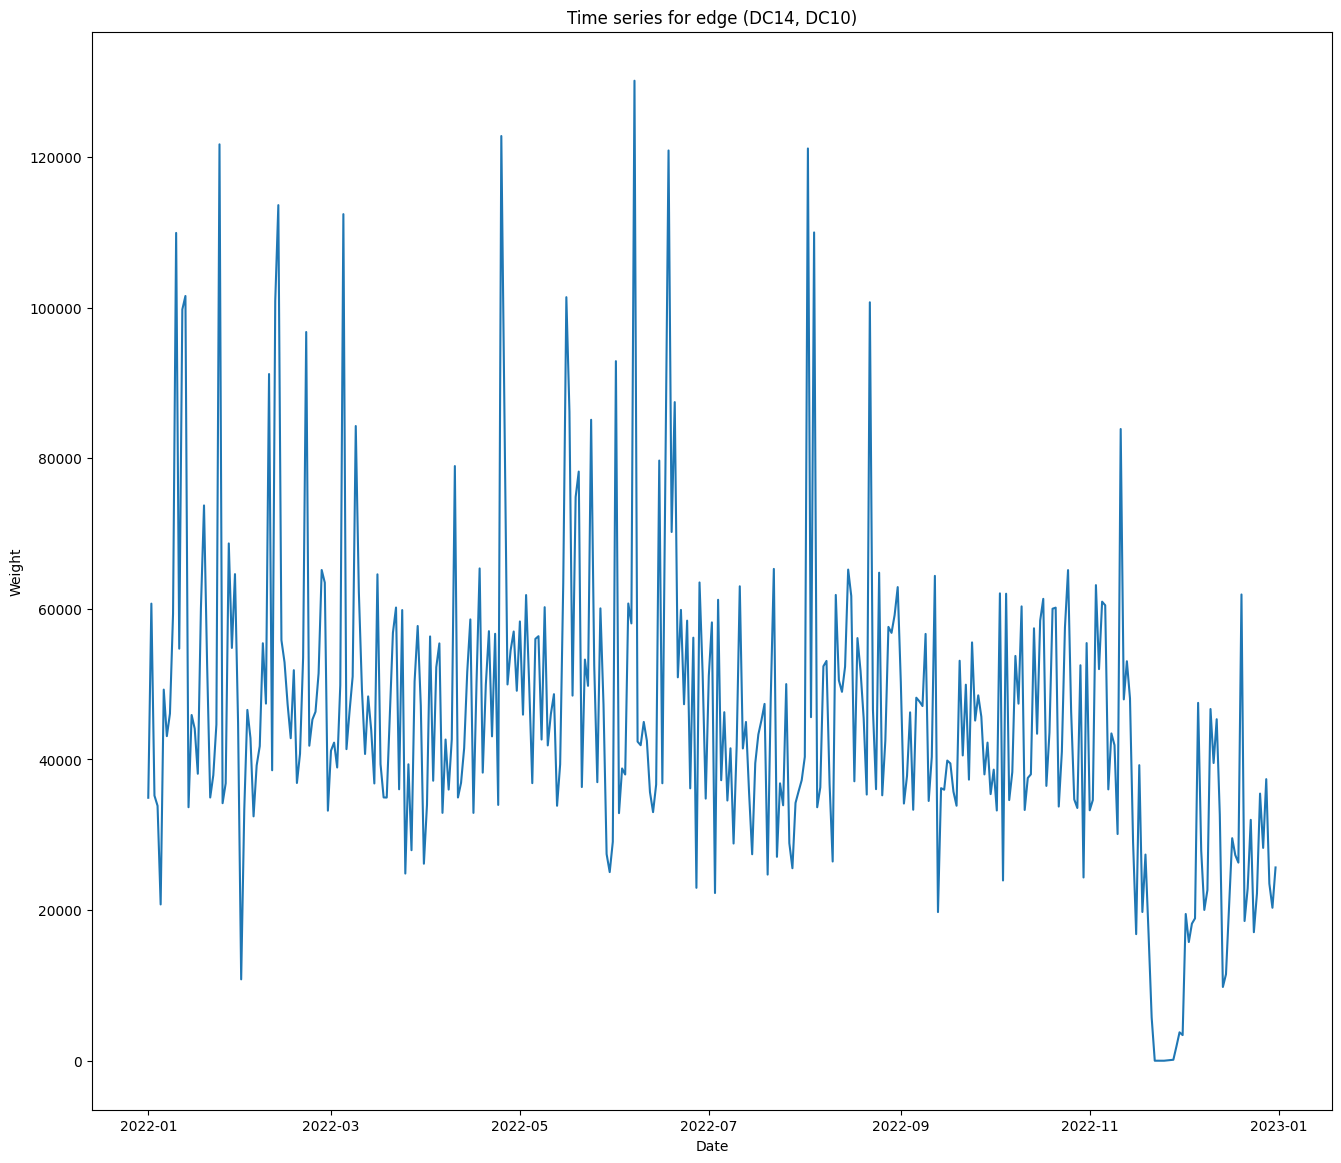

In [7]:
# 获取边(node1, node2)的时间序列和权值序列
dates = []
weights = []
node1='DC14'
node2='DC10'
Timestamp= datetime(2022, 1, 1, 0, 0) 
Timestamp.timestamp()
for date, graph in graphs_by_date.items():
    if date>=Timestamp:
        if graph.has_edge(node1, node2):
            dates.append(date)
            weights.append(graph[node1][node2]['weight'])

# 绘制时序图
fig, ax = plt.subplots(figsize=(16, 14))
ax.plot(dates, weights)
ax.set_xlabel('Date')
ax.set_ylabel('Weight')
ax.set_title(f'Time series for edge ({node1}, {node2})')
plt.show()

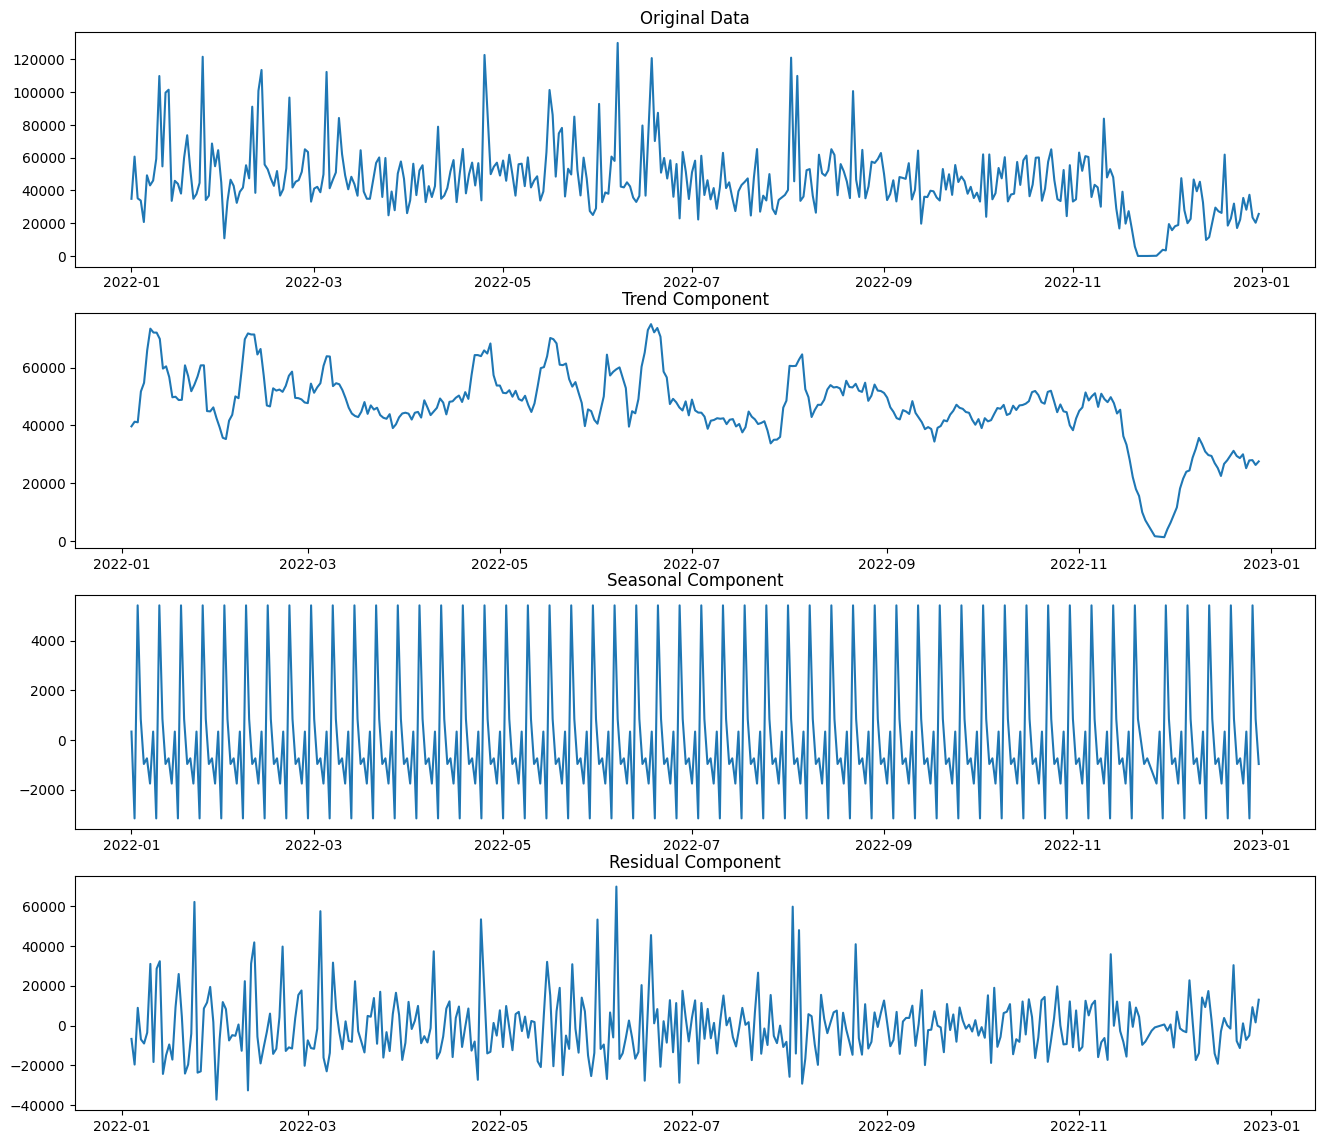

In [8]:
df = pd.DataFrame({'weight': weights}, index=pd.to_datetime(dates))
# 对时间序列进行分解
result = seasonal_decompose(df, model='additive', period=7)
# 绘制分解结果
fig, axs = plt.subplots(4, 1, figsize=(16, 14))
axs[0].set_title('Original Data')
axs[0].plot(df)

axs[1].set_title('Trend Component')
axs[1].plot(result.trend)

axs[2].set_title('Seasonal Component')
axs[2].plot(result.seasonal)

axs[3].set_title('Residual Component')
axs[3].plot(result.resid)

plt.show()

In [9]:
# 对分解结果进行预测
forecast = result.trend + result.seasonal
forecast = forecast['2022-01-01':'2022-01-31']
print(forecast)

2022-01-01             NaN
2022-01-02             NaN
2022-01-03             NaN
2022-01-04    40531.912045
2022-01-05    40312.545098
2022-01-06    40346.771989
2022-01-07    50002.371429
2022-01-08    55080.220168
2022-01-09    62862.982073
2022-01-10    78921.197199
2022-01-11    72990.340616
2022-01-12    71148.116527
2022-01-13    69198.057703
2022-01-14    57922.514286
2022-01-15    60783.220168
2022-01-16    53563.553501
2022-01-17    55175.768627
2022-01-18    50777.626331
2022-01-19    47820.687955
2022-01-20    48128.914846
2022-01-21    59049.800000
2022-01-22    57452.077311
2022-01-23    48679.124930
2022-01-24    59559.054342
2022-01-25    57813.483473
2022-01-26    59811.973669
2022-01-27    60068.200560
2022-01-28    43212.942857
2022-01-29    45190.648739
2022-01-30    43079.982073
2022-01-31    47980.054342
dtype: float64


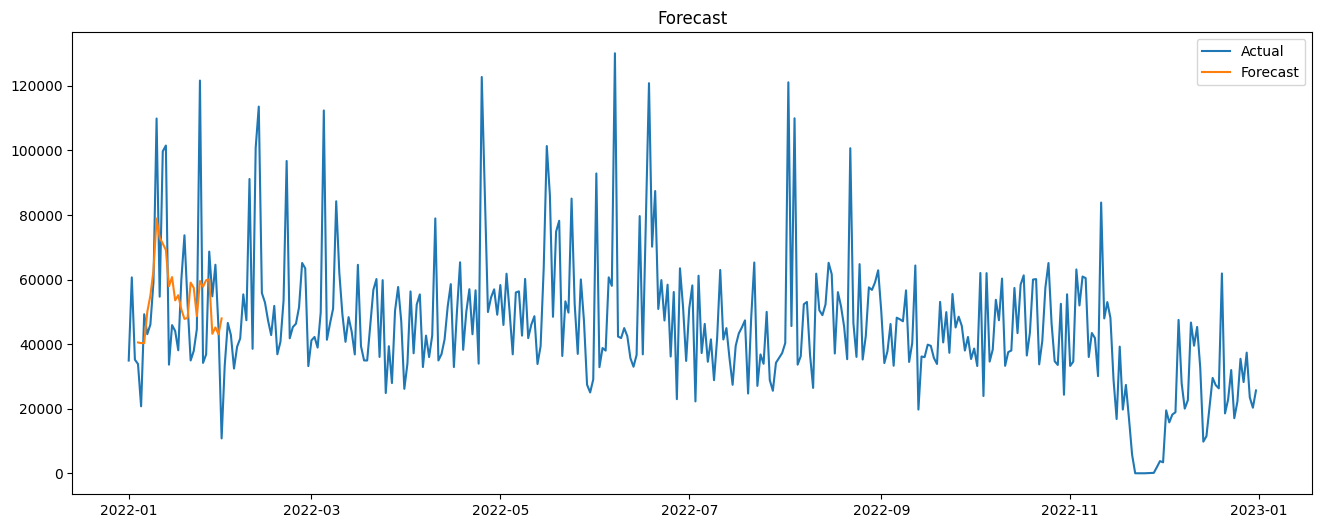

In [10]:
# 绘制预测结果
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
ax.set_title('Forecast')
ax.plot(df['2022-01-01':'2023-01-31'], label='Actual')
ax.plot(forecast, label='Forecast')
ax.legend()
plt.show()